Data Loading and Preprocessing Module

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import zipfile
import warnings
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import hdbscan

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

def extract_zip_files():
    """Extract uploaded zip files with robust error handling"""
    print("Checking for data files...")

    # Define possible paths for zip files
    possible_zip_paths = [
        '/content/depth20_1000ms.zip',
        '/content/aggTrade.zip',
        '/content/depth20_1000ms-*.zip',
        '/content/aggTrade-*.zip'
    ]

    # Try to find and extract zip files
    for pattern in possible_zip_paths:
        import glob
        for zip_path in glob.glob(pattern):
            try:
                print(f"Extracting {zip_path}...")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall('/content/')
                print(f"Successfully extracted {zip_path}")
            except Exception as e:
                print(f"Error extracting {zip_path}: {e}")

    # Create directories if they don't exist
    depth_dir = '/content/depth20_1000ms'
    trade_dir = '/content/aggTrade'

    os.makedirs(depth_dir, exist_ok=True)
    os.makedirs(trade_dir, exist_ok=True)

    # List available files
    print("\nAvailable depth files:")
    for root, dirs, files in os.walk(depth_dir):
        for file in files:
            if file.endswith('.txt'):
                print(f" - {os.path.join(root, file)}")

    print("\nAvailable trade files:")
    for root, dirs, files in os.walk(trade_dir):
        for file in files:
            if file.endswith('.txt'):
                print(f" - {os.path.join(root, file)}")

def find_data_files():
    """Find all available data files with proper error handling"""
    depth_files = []
    trade_files = []

    # Search for depth files
    for root, dirs, files in os.walk('/content/'):
        for file in files:
            if file.endswith('.txt'):
                if 'depth20' in root.lower():
                    depth_files.append(os.path.join(root, file))
                elif 'aggtrade' in root.lower():
                    trade_files.append(os.path.join(root, file))

    # If no files found, try alternative locations
    if not depth_files:
        print("No depth files found in standard location, searching elsewhere...")
        for root, dirs, files in os.walk('/content/'):
            for file in files:
                if file.endswith('.txt') and 'BNBFDUSD' in file:
                    with open(os.path.join(root, file), 'r') as f:
                        first_line = f.readline()
                        if 'Bid' in first_line or 'Ask' in first_line:
                            depth_files.append(os.path.join(root, file))
                        elif 'Trade' in first_line or 'Price' in first_line:
                            trade_files.append(os.path.join(root, file))

    print(f"Found {len(depth_files)} depth files and {len(trade_files)} trade files")

    # Match files by date
    paired_files = []
    for depth_file in depth_files:
        depth_basename = os.path.basename(depth_file)
        for trade_file in trade_files:
            trade_basename = os.path.basename(trade_file)
            # Check if both files contain the same date
            if depth_basename == trade_basename:
                paired_files.append((depth_file, trade_file))
                break

    print(f"Found {len(paired_files)} paired files")
    return paired_files

def load_data_files(paired_files):
    """Load data files with proper error handling and memory optimization"""
    data_pairs = []

    for depth_file, trade_file in tqdm(paired_files, desc="Loading data files"):
        try:
            # Extract date from filename
            filename = os.path.basename(depth_file)
            date_str = filename.split('_')[-1].split('.')[0]

            # Load depth data - read only necessary columns to save memory
            depth_df = pd.read_csv(depth_file)

            # Load trade data - read only necessary columns to save memory
            trade_df = pd.read_csv(trade_file)

            # Standardize column names
            if 'Time' in depth_df.columns:
                depth_df.rename(columns={'Time': 'timestamp'}, inplace=True)
            if 'Time' in trade_df.columns:
                trade_df.rename(columns={'Time': 'timestamp'}, inplace=True)

            # Convert timestamp to datetime
            try:
                depth_df['timestamp'] = pd.to_datetime(depth_df['timestamp'])
                trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'])
            except:
                # If direct conversion fails, try extracting datetime part
                depth_df['timestamp'] = pd.to_datetime(depth_df['timestamp'].str.extract(r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})')[0])
                trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'].str.extract(r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})')[0])

            # Reset index to avoid duplicate index issues
            depth_df = depth_df.reset_index(drop=True)
            trade_df = trade_df.reset_index(drop=True)

            # Set timestamp as index
            depth_df.set_index('timestamp', inplace=True)
            trade_df.set_index('timestamp', inplace=True)

            # Store data pair
            data_pairs.append({
                'date': date_str,
                'depth': depth_df,
                'trade': trade_df
            })

            print(f"Successfully loaded {filename}")

        except Exception as e:
            print(f"Error loading {depth_file} and {trade_file}: {e}")

    return data_pairs


Feature Engineering Module

In [22]:
def extract_order_book_features(depth_df, sample_rate='5min'):
    """Extract meaningful features from order book data with downsampling for efficiency"""
    # Downsample data to reduce processing time
    depth_df = depth_df.resample(sample_rate).first().dropna()

    features = pd.DataFrame(index=depth_df.index)

    # Identify bid/ask columns
    bid_price_cols = [col for col in depth_df.columns if 'BidPrice' in col or 'bid_price' in col.lower()]
    ask_price_cols = [col for col in depth_df.columns if 'AskPrice' in col or 'ask_price' in col.lower()]
    bid_qty_cols = [col for col in depth_df.columns if 'BidQty' in col or 'bid_qty' in col.lower()]
    ask_qty_cols = [col for col in depth_df.columns if 'AskQty' in col or 'ask_qty' in col.lower()]

    # Sort columns to ensure correct order
    bid_price_cols.sort()
    ask_price_cols.sort()
    bid_qty_cols.sort()
    ask_qty_cols.sort()

    # Check if we have the necessary columns
    if not bid_price_cols or not ask_price_cols or not bid_qty_cols or not ask_qty_cols:
        print("Warning: Missing necessary order book columns")
        return features

    # Basic order book features
    features['best_bid'] = depth_df[bid_price_cols[0]]
    features['best_ask'] = depth_df[ask_price_cols[0]]
    features['mid_price'] = (features['best_bid'] + features['best_ask']) / 2
    features['spread'] = features['best_ask'] - features['best_bid']
    features['spread_pct'] = features['spread'] / features['mid_price']

    # Order book imbalance
    features['bid_qty_1'] = depth_df[bid_qty_cols[0]]
    features['ask_qty_1'] = depth_df[ask_qty_cols[0]]

    # Handle zero quantities to avoid division by zero
    sum_qty = features['bid_qty_1'] + features['ask_qty_1']
    features['imbalance'] = (features['bid_qty_1'] - features['ask_qty_1']) / sum_qty.replace(0, 1)

    # Microprice (price weighted by opposite side quantity)
    features['microprice'] = (features['best_bid'] * features['ask_qty_1'] +
                             features['best_ask'] * features['bid_qty_1']) / sum_qty.replace(0, 1)

    # Cumulative depth - use only first 5 levels for efficiency
    level_limit = min(5, len(bid_qty_cols))
    features['cum_bid_qty'] = depth_df[bid_qty_cols[:level_limit]].sum(axis=1)
    features['cum_ask_qty'] = depth_df[ask_qty_cols[:level_limit]].sum(axis=1)
    sum_cum_qty_all = features['cum_bid_qty'] + features['cum_ask_qty']
    features['depth_imbalance'] = (features['cum_bid_qty'] - features['cum_ask_qty']) / sum_cum_qty_all.replace(0, 1)

    # Calculate returns and volatility
    features['mid_price_shift'] = features['mid_price'].shift(1)
    features['mid_price_return'] = np.log(features['mid_price'] / features['mid_price_shift'])

    # Rolling volatility (5 periods)
    window_size = 5
    features['volatility_5'] = features['mid_price_return'].rolling(window=window_size).std().fillna(0)

    # Mean-reversion indicators
    features['price_deviation'] = features['mid_price'] - features['mid_price'].rolling(window=window_size).mean().fillna(method='bfill')
    features['price_deviation_zscore'] = features['price_deviation'] / features['mid_price'].rolling(window=window_size).std().fillna(method='bfill').replace(0, 1)

    # Clean up NaN values
    features = features.fillna(0)

    # Time-based features
    features['hour'] = features.index.hour
    features['minute'] = features.index.minute

    return features

def extract_trade_features(trade_df, freq='5min'):
    """Extract meaningful features from trade data with downsampling for efficiency"""
    # Resample data to the specified frequency
    volume_features = pd.DataFrame()

    # Find price and quantity columns
    price_cols = [col for col in trade_df.columns if 'Price' in col or 'price' in col.lower()]
    qty_cols = [col for col in trade_df.columns if any(qty_str in col.lower() for qty_str in ['qty', 'quantity', 'size', 'volume'])]

    if not price_cols or not qty_cols:
        print("Warning: Missing necessary trade columns")
        return volume_features

    price_col = price_cols[0]
    qty_col = qty_cols[0]

    # Trading activity features
    volume_resampled = trade_df.resample(freq)

    # Volume
    volume_features['total_volume'] = volume_resampled[qty_col].sum()

    # Average trade size
    volume_features['avg_trade_size'] = volume_resampled[qty_col].mean()

    # Number of trades
    volume_features['num_trades'] = volume_resampled.size()

    # Price related
    volume_features['vwap'] = (trade_df[price_col] * trade_df[qty_col]).resample(freq).sum() / trade_df[qty_col].resample(freq).sum()

    # Price changes
    volume_features['price_high'] = trade_df[price_col].resample(freq).max()
    volume_features['price_low'] = trade_df[price_col].resample(freq).min()
    volume_features['price_range'] = volume_features['price_high'] - volume_features['price_low']
    volume_features['price_close'] = trade_df[price_col].resample(freq).last()
    volume_features['price_open'] = trade_df[price_col].resample(freq).first()

    # Calculate returns
    volume_features['return'] = np.log(volume_features['price_close'] / volume_features['price_close'].shift(1))

    # Volatility metrics
    volume_features['volatility'] = volume_features['return'].rolling(window=5).std().fillna(0)

    # Clean up NaN values
    volume_features = volume_features.fillna(0)

    return volume_features

def combine_features(order_book_features, trade_features):
    """Combine order book and trade features with proper time alignment and memory efficiency"""
    # Reset indices to avoid duplicate index issues
    order_book_reset = order_book_features.reset_index()
    trade_features_reset = trade_features.reset_index()

    # Merge on timestamp
    combined = pd.merge_asof(
        order_book_reset.sort_values('timestamp'),
        trade_features_reset.sort_values('timestamp'),
        on='timestamp',
        direction='nearest'
    )

    # Set timestamp as index again
    combined.set_index('timestamp', inplace=True)

    # Fill missing values
    combined.fillna(method='ffill', inplace=True)
    combined.fillna(method='bfill', inplace=True)

    # Drop any remaining NaN values
    combined.dropna(inplace=True)

    return combined

def add_derived_features(features):
    """Add derived features for regime detection - optimized for performance"""
    # Create a copy to avoid modifying the original
    enhanced = features.copy()

    # Add rolling features - use only one window size for efficiency
    window_size = 10

    # Price momentum
    enhanced[f'price_momentum_{window_size}'] = enhanced['mid_price'].pct_change(window_size)

    # Volatility
    enhanced[f'volatility_{window_size}'] = enhanced['mid_price'].pct_change().rolling(window_size).std()

    # Mean reversion indicator
    enhanced[f'price_deviation_{window_size}'] = enhanced['mid_price'] - enhanced['mid_price'].rolling(window_size).mean()
    enhanced[f'price_deviation_zscore_{window_size}'] = enhanced[f'price_deviation_{window_size}'] / enhanced['mid_price'].rolling(window_size).std().replace(0, 1)

    # Clean up NaN values
    enhanced.fillna(0, inplace=True)

    return enhanced


Clustering and Regime Detection Module

In [23]:
def fast_determine_optimal_clusters(features, max_clusters=8):
    """Faster determination of optimal number of clusters using MiniBatchKMeans"""
    # Select features for clustering (exclude time-based features)
    features_subset = features.drop(columns=['hour', 'minute'], errors='ignore')

    # Sample data if it's too large (for faster processing)
    if len(features_subset) > 1000:
        features_subset = features_subset.sample(n=1000, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_subset)

    # Calculate metrics for different numbers of clusters
    silhouette_scores = []
    inertia_values = []

    for n_clusters in range(2, max_clusters + 1):
        # Use MiniBatchKMeans for faster processing
        kmeans = MiniBatchKMeans(n_clusters=n_clusters,
                                random_state=42,
                                batch_size=100,
                                n_init=10)
        labels = kmeans.fit_predict(scaled_features)

        # Calculate metrics
        if len(np.unique(labels)) > 1:  # Ensure we have at least 2 clusters
            silhouette_scores.append(silhouette_score(scaled_features, labels))
        else:
            silhouette_scores.append(0)
        inertia_values.append(kmeans.inertia_)

    # Plot metrics
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Silhouette score (higher is better)
    axes[0].plot(range(2, max_clusters + 1), silhouette_scores, 'o-')
    axes[0].set_title('Silhouette Score')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('Score (higher is better)')
    axes[0].grid(True)

    # Elbow method
    axes[1].plot(range(2, max_clusters + 1), inertia_values, 'o-')
    axes[1].set_title('Elbow Method')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Inertia')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Suggest optimal number of clusters
    silhouette_optimal = np.argmax(silhouette_scores) + 2

    print(f"Suggested optimal clusters based on Silhouette Score: {silhouette_optimal}")
    print(f"Examine the Elbow plot to confirm this selection")

    return silhouette_optimal

def detect_regimes(features, n_clusters=5, method='kmeans'):
    """Detect market regimes using clustering - optimized for performance"""
    # Select features for clustering (exclude time-based features)
    features_subset = features.drop(columns=['hour', 'minute'], errors='ignore')

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features_subset)

    # Apply clustering algorithm
    if method == 'kmeans':
        # Use MiniBatchKMeans for faster processing
        model = MiniBatchKMeans(n_clusters=n_clusters,
                               random_state=42,
                               batch_size=100,
                               n_init=10)
        labels = model.fit_predict(scaled_features)

        # Get cluster centers
        centers = scaler.inverse_transform(model.cluster_centers_)
        cluster_df = pd.DataFrame(centers, columns=features_subset.columns)

    elif method == 'gmm':
        model = GaussianMixture(n_components=n_clusters,
                               random_state=42,
                               max_iter=100,
                               n_init=3)
        labels = model.fit_predict(scaled_features)

        # Get cluster centers
        centers = scaler.inverse_transform(model.means_)
        cluster_df = pd.DataFrame(centers, columns=features_subset.columns)

    elif method == 'hdbscan':
        # HDBSCAN with optimized parameters
        model = hdbscan.HDBSCAN(min_cluster_size=max(5, len(features) // 200),
                               min_samples=max(5, len(features) // 400),
                               cluster_selection_epsilon=0.5,
                               algorithm='best')
        labels = model.fit_predict(scaled_features)

        # Get cluster characteristics
        cluster_df = pd.DataFrame()
        for cluster in np.unique(labels):
            if cluster >= 0:  # Skip noise points labeled -1
                mask = labels == cluster
                cluster_df[f'Cluster_{cluster}'] = features_subset[mask].mean()
        cluster_df = cluster_df.T

    # Add labels to features
    features_with_regimes = features.copy()
    features_with_regimes['regime'] = labels

    # Evaluate clustering
    if method != 'hdbscan' or len(np.unique(labels)) > 1:
        try:
            # Use a sample if dataset is large
            if len(scaled_features) > 1000:
                sample_indices = np.random.choice(len(scaled_features), 1000, replace=False)
                silhouette = silhouette_score(scaled_features[sample_indices], labels[sample_indices])
            else:
                silhouette = silhouette_score(scaled_features, labels)
            print(f"Silhouette Score: {silhouette:.4f}")
        except:
            print("Could not calculate clustering metrics")

    return features_with_regimes, cluster_df, model, scaler

def characterize_regimes(cluster_df):
    """Characterize market regimes based on their properties"""
    # Define thresholds for classification
    thresholds = {
        'volatility_5': {'high': 0.0005, 'low': 0.0001},
        'volatility_10': {'high': 0.0005, 'low': 0.0001},
        'price_deviation_zscore_10': {'high': 0.5, 'low': -0.5},
        'depth_imbalance': {'high': 0.2, 'low': -0.2},
        'spread_pct': {'high': 0.001, 'low': 0.0005}
    }

    # Initialize regime characteristics
    regime_characteristics = {}

    # Characterize each regime
    for idx, row in cluster_df.iterrows():
        # Initialize characteristics
        characteristics = []

        # Trending vs Mean-reverting
        deviation_keys = [k for k in row.index if 'price_deviation_zscore' in k]
        if deviation_keys:
            key = deviation_keys[0]
            if row[key] > thresholds['price_deviation_zscore_10']['high']:
                characteristics.append("Trending")
            elif row[key] < thresholds['price_deviation_zscore_10']['low']:
                characteristics.append("Mean-reverting")
            else:
                characteristics.append("Neutral")

        # Volatile vs Stable
        volatility_keys = [k for k in row.index if 'volatility' in k]
        if volatility_keys:
            key = volatility_keys[0]
            threshold_key = 'volatility_10' if 'volatility_10' in thresholds else 'volatility_5'
            if row[key] > thresholds[threshold_key]['high']:
                characteristics.append("Volatile")
            elif row[key] < thresholds[threshold_key]['low']:
                characteristics.append("Stable")
            else:
                characteristics.append("Moderate volatility")

        # Liquid vs Illiquid
        if 'spread_pct' in row and 'depth_imbalance' in row:
            if row['spread_pct'] < thresholds['spread_pct']['low'] and abs(row['depth_imbalance']) < 0.1:
                characteristics.append("Liquid")
            elif row['spread_pct'] > thresholds['spread_pct']['high'] or abs(row['depth_imbalance']) > 0.3:
                characteristics.append("Illiquid")
            else:
                characteristics.append("Moderate liquidity")

        # Store characteristics
        regime_name = f"Regime {idx}" if isinstance(idx, int) else idx
        regime_characteristics[regime_name] = " & ".join(characteristics)

    return regime_characteristics


Visualization Module

In [24]:
def visualize_regimes(features_with_regimes, cluster_df, regime_characteristics, date_str):
    """Create optimized visualizations of detected market regimes"""
    # 1. Plot price with regimes - use downsampling for large datasets
    if len(features_with_regimes) > 1000:
        # Downsample for visualization
        sample_size = min(1000, len(features_with_regimes))
        sample_indices = np.linspace(0, len(features_with_regimes)-1, sample_size, dtype=int)
        plot_data = features_with_regimes.iloc[sample_indices]
    else:
        plot_data = features_with_regimes

    plt.figure(figsize=(14, 6))

    # Create a colormap for regimes
    unique_regimes = sorted(plot_data['regime'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_regimes)))

    # Plot mid price
    ax = plt.gca()
    ax.plot(plot_data.index, plot_data['mid_price'], 'k-', alpha=0.3, label='Mid Price')

    # Plot regimes
    for i, regime in enumerate(unique_regimes):
        if regime >= 0:  # Skip noise points in HDBSCAN
            mask = plot_data['regime'] == regime
            ax.scatter(plot_data.index[mask],
                      plot_data['mid_price'][mask],
                      color=colors[i],
                      label=f"{regime}: {regime_characteristics.get(f'Regime {regime}', '')}",
                      alpha=0.7, s=30)

    plt.title(f'Market Regimes - {date_str}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Create transition probability matrix
    features_with_regimes['next_regime'] = features_with_regimes['regime'].shift(-1)
    features_with_regimes.dropna(subset=['next_regime'], inplace=True)

    transition_matrix = pd.crosstab(
        features_with_regimes['regime'],
        features_with_regimes['next_regime'],
        normalize='index'
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title(f'Regime Transition Probabilities - {date_str}', fontsize=16)
    plt.xlabel('Next Regime', fontsize=14)
    plt.ylabel('Current Regime', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Free memory
    plt.close('all')
    gc.collect()

    return transition_matrix


Analysis Pipeline Module

In [25]:
def analyze_single_day(data_pair, n_clusters=None):
    """Analyze a single day's worth of data with optimized performance"""
    date_str = data_pair['date']
    depth_df = data_pair['depth']
    trade_df = data_pair['trade']

    print(f"\n{'='*50}")
    print(f"Analyzing data for {date_str}")
    print(f"{'='*50}")

    # Extract features with downsampling for efficiency
    print("Extracting order book features...")
    order_book_features = extract_order_book_features(depth_df, sample_rate='5min')

    print("Extracting trade features...")
    trade_features = extract_trade_features(trade_df, freq='5min')

    print("Combining features...")
    combined_features = combine_features(order_book_features, trade_features)

    print("Adding derived features...")
    enhanced_features = add_derived_features(combined_features)

    # Free memory
    del order_book_features, trade_features, combined_features
    gc.collect()

    # Determine optimal number of clusters if not provided
    if n_clusters is None:
        print("\nDetermining optimal number of clusters...")
        n_clusters = fast_determine_optimal_clusters(enhanced_features, max_clusters=6)

    # Detect regimes
    print(f"\nDetecting market regimes with {n_clusters} clusters...")
    features_with_regimes, cluster_df, model, scaler = detect_regimes(
        enhanced_features, n_clusters=n_clusters, method='kmeans')

    # Characterize regimes
    print("\nCharacterizing market regimes...")
    regime_characteristics = characterize_regimes(cluster_df)

    # Print regime characteristics
    print("\nRegime Characteristics:")
    for regime, characteristics in regime_characteristics.items():
        print(f"- {regime}: {characteristics}")

    # Visualize regimes
    print("\nVisualizing market regimes...")
    transition_matrix = visualize_regimes(features_with_regimes, cluster_df, regime_characteristics, date_str)

    # Free memory
    gc.collect()

    return features_with_regimes, cluster_df, regime_characteristics

def create_summary_report(all_results, all_cluster_dfs, all_regime_characteristics):
    """Create a comprehensive summary report of all analyzed days"""
    print("\n" + "="*50)
    print("MARKET REGIME DETECTION SUMMARY REPORT")
    print("="*50)

    for date_str, features_with_regimes in all_results.items():
        cluster_df = all_cluster_dfs[date_str]
        regime_characteristics = all_regime_characteristics[date_str]

        print(f"\nDate: {date_str}")
        print("-"*30)

        # Regime distribution
        regime_counts = features_with_regimes['regime'].value_counts().sort_index()
        total_points = len(features_with_regimes)

        print("Regime Distribution:")
        for regime, count in regime_counts.items():
            if regime >= 0:  # Skip noise points in HDBSCAN
                percentage = (count / total_points) * 100
                characteristics = regime_characteristics.get(f"Regime {regime}", "")
                print(f"  Regime {regime} ({characteristics}): {count} points ({percentage:.2f}%)")

        # Time spent in each regime
        print("\nTime Spent in Each Regime:")
        for regime in sorted(features_with_regimes['regime'].unique()):
            if regime >= 0:  # Skip noise points in HDBSCAN
                regime_data = features_with_regimes[features_with_regimes['regime'] == regime]
                start_time = regime_data.index.min().strftime('%H:%M:%S')
                end_time = regime_data.index.max().strftime('%H:%M:%S')
                duration = regime_data.index.max() - regime_data.index.min()
                hours, remainder = divmod(duration.total_seconds(), 3600)
                minutes, seconds = divmod(remainder, 60)
                print(f"  Regime {regime}: Start={start_time}, End={end_time}, Duration={int(hours)}h {int(minutes)}m {int(seconds)}s")

        # Regime characteristics
        print("\nRegime Characteristics:")

        # Select important features for display
        important_features = ['spread', 'volatility_5', 'depth_imbalance',
                             'price_deviation_zscore_10', 'mid_price', 'imbalance']

        # Filter only available features
        available_features = [f for f in important_features if f in cluster_df.columns]

        # Print feature table
        print("\n Feature" + " "*8 + "| " + " | ".join([f"Regime {r}" for r in sorted(cluster_df.index)]))
        print(" " + "-"*50)

        for feature in available_features:
            # Format feature name with padding
            feature_display = feature[:12].ljust(14)

            # Get values for each regime
            values = []
            for idx in sorted(cluster_df.index):
                # Format values based on their magnitude
                value = cluster_df.loc[idx, feature]
                if abs(value) < 0.01:
                    val_str = f"{value:.6f}"
                elif abs(value) < 1:
                    val_str = f"{value:.4f}"
                else:
                    val_str = f"{value:.2f}"
                values.append(val_str.rjust(8))

            print(f" {feature_display}| {' | '.join(values)}")


Main Execution Module

Checking for data files...
Extracting /content/depth20_1000ms-20250420T101210Z-001.zip...
Successfully extracted /content/depth20_1000ms-20250420T101210Z-001.zip
Extracting /content/aggTrade-20250420T101158Z-001.zip...
Successfully extracted /content/aggTrade-20250420T101158Z-001.zip

Available depth files:
 - /content/depth20_1000ms/BNBFDUSD_20250314.txt
 - /content/depth20_1000ms/BNBFDUSD_20250317.txt
 - /content/depth20_1000ms/BNBFDUSD_20250315.txt
 - /content/depth20_1000ms/BNBFDUSD_20250316.txt

Available trade files:
 - /content/aggTrade/BNBFDUSD_20250314.txt
 - /content/aggTrade/BNBFDUSD_20250317.txt
 - /content/aggTrade/BNBFDUSD_20250315.txt
 - /content/aggTrade/BNBFDUSD_20250316.txt
Found 4 depth files and 4 trade files
Found 4 paired files


Loading data files:  25%|██▌       | 1/4 [00:05<00:16,  5.54s/it]

Successfully loaded BNBFDUSD_20250314.txt


Loading data files:  50%|█████     | 2/4 [00:10<00:09,  4.93s/it]

Successfully loaded BNBFDUSD_20250317.txt


Loading data files:  75%|███████▌  | 3/4 [00:12<00:03,  3.83s/it]

Successfully loaded BNBFDUSD_20250315.txt


Loading data files: 100%|██████████| 4/4 [00:14<00:00,  3.69s/it]

Successfully loaded BNBFDUSD_20250316.txt
Using 5 clusters for all days for consistency and efficiency

Analyzing data for 20250314
Extracting order book features...
Extracting trade features...
Combining features...
Adding derived features...



Detecting market regimes with 5 clusters...
Silhouette Score: 0.0989

Characterizing market regimes...

Regime Characteristics:
- Regime 0: Trending & Volatile & Liquid
- Regime 1: Mean-reverting & Volatile & Liquid
- Regime 2: Mean-reverting & Volatile & Liquid
- Regime 3: Neutral & Volatile & Moderate liquidity
- Regime 4: Trending & Volatile & Liquid

Visualizing market regimes...


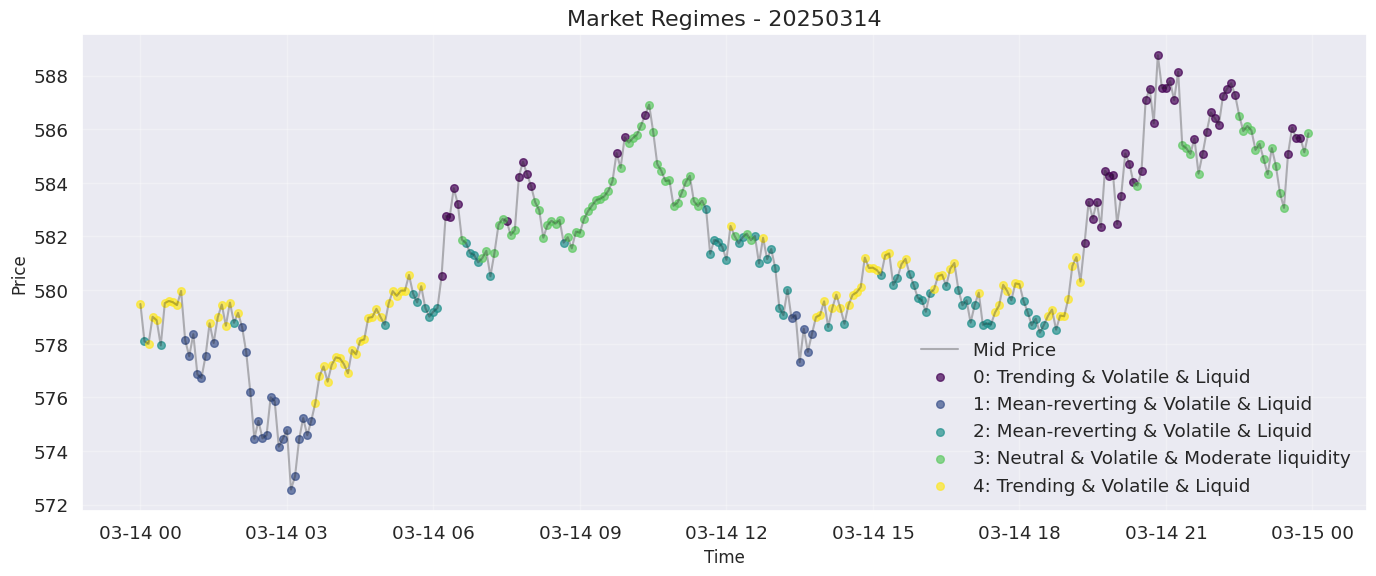

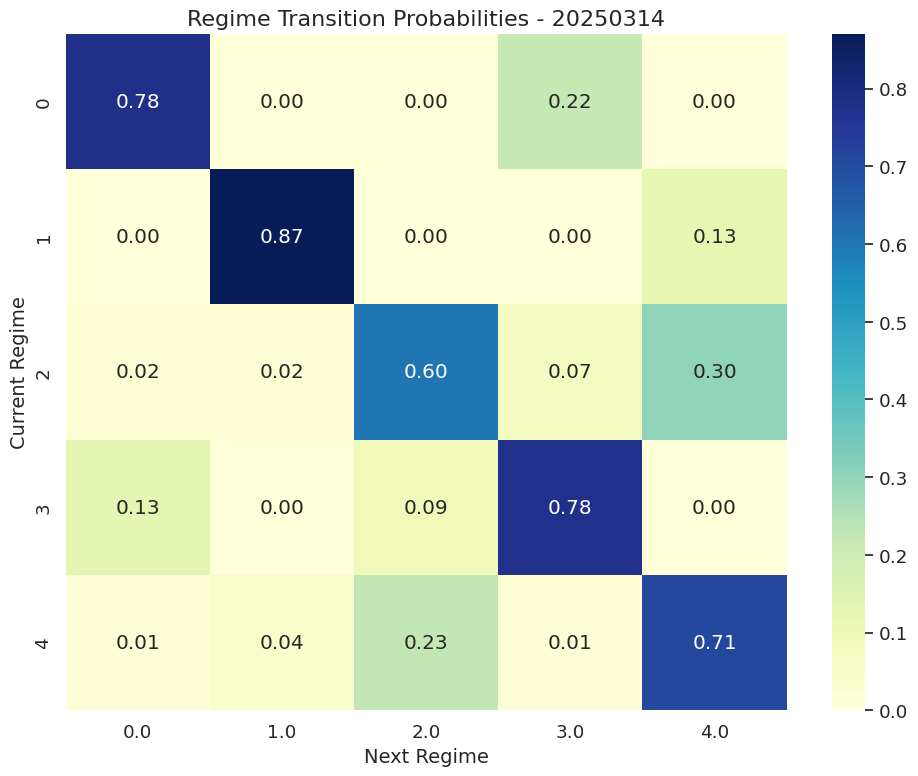


Analyzing data for 20250317
Extracting order book features...
Extracting trade features...
Combining features...
Adding derived features...

Detecting market regimes with 5 clusters...
Silhouette Score: 0.1565

Characterizing market regimes...

Regime Characteristics:
- Regime 0: Mean-reverting & Volatile & Liquid
- Regime 1: Mean-reverting & Volatile & Liquid
- Regime 2: Neutral & Volatile & Liquid
- Regime 3: Trending & Volatile & Liquid
- Regime 4: Neutral & Volatile & Liquid

Visualizing market regimes...


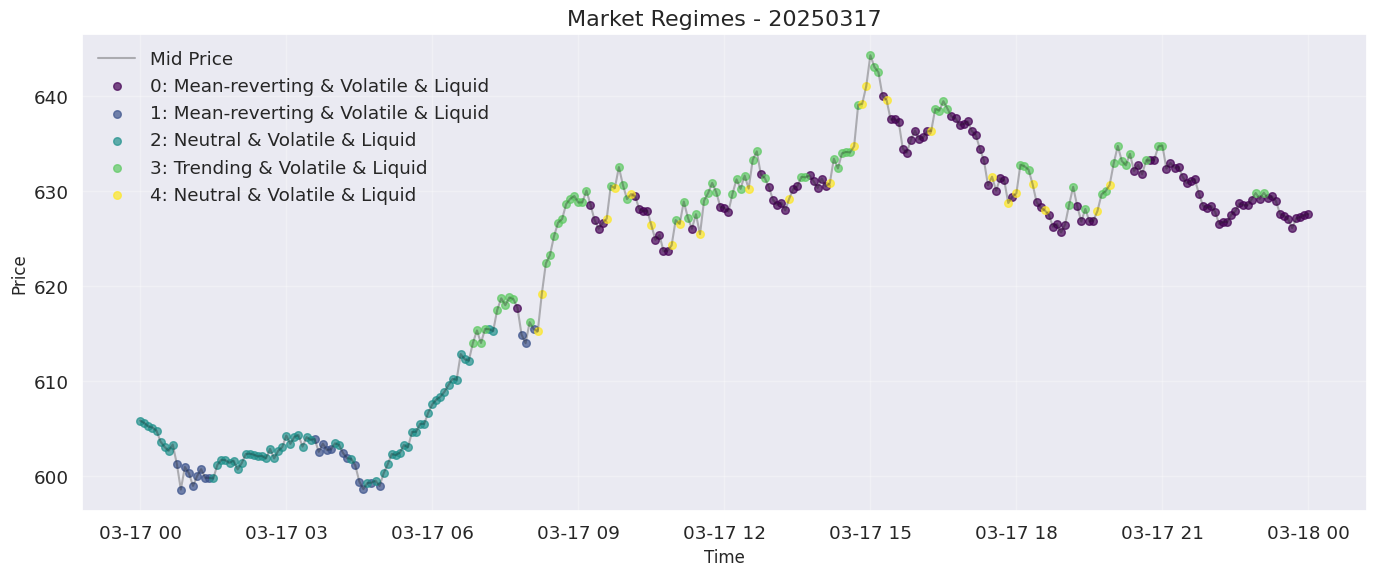

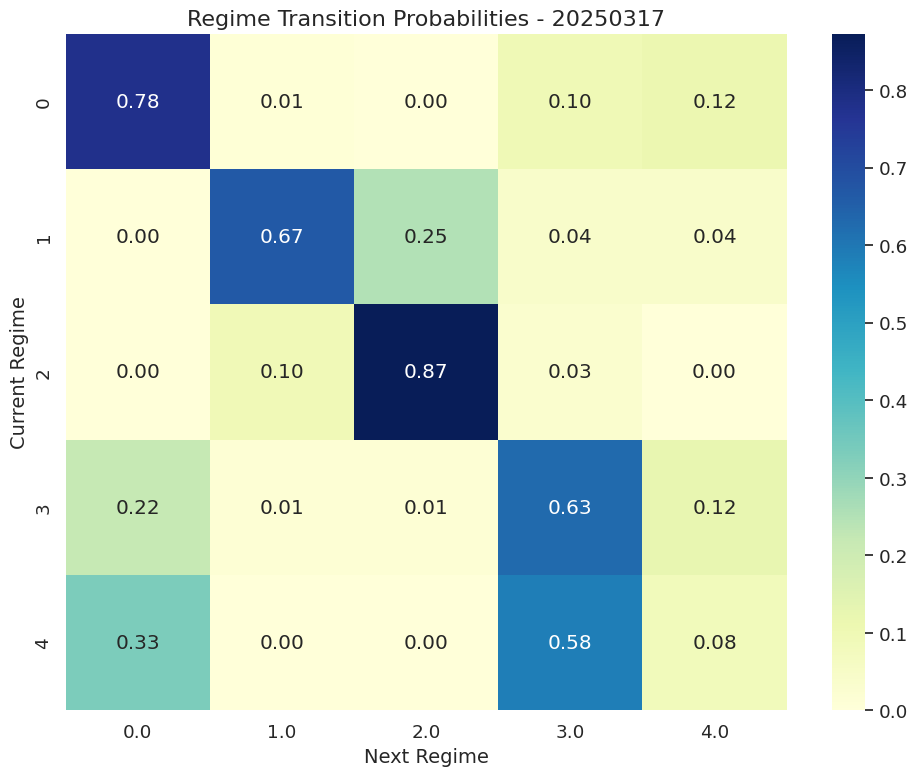


Analyzing data for 20250315
Extracting order book features...
Extracting trade features...
Combining features...
Adding derived features...

Detecting market regimes with 5 clusters...
Silhouette Score: 0.1065

Characterizing market regimes...

Regime Characteristics:
- Regime 0: Trending & Volatile & Liquid
- Regime 1: Mean-reverting & Volatile & Liquid
- Regime 2: Trending & Volatile & Moderate liquidity
- Regime 3: Neutral & Volatile & Liquid
- Regime 4: Trending & Volatile & Moderate liquidity

Visualizing market regimes...


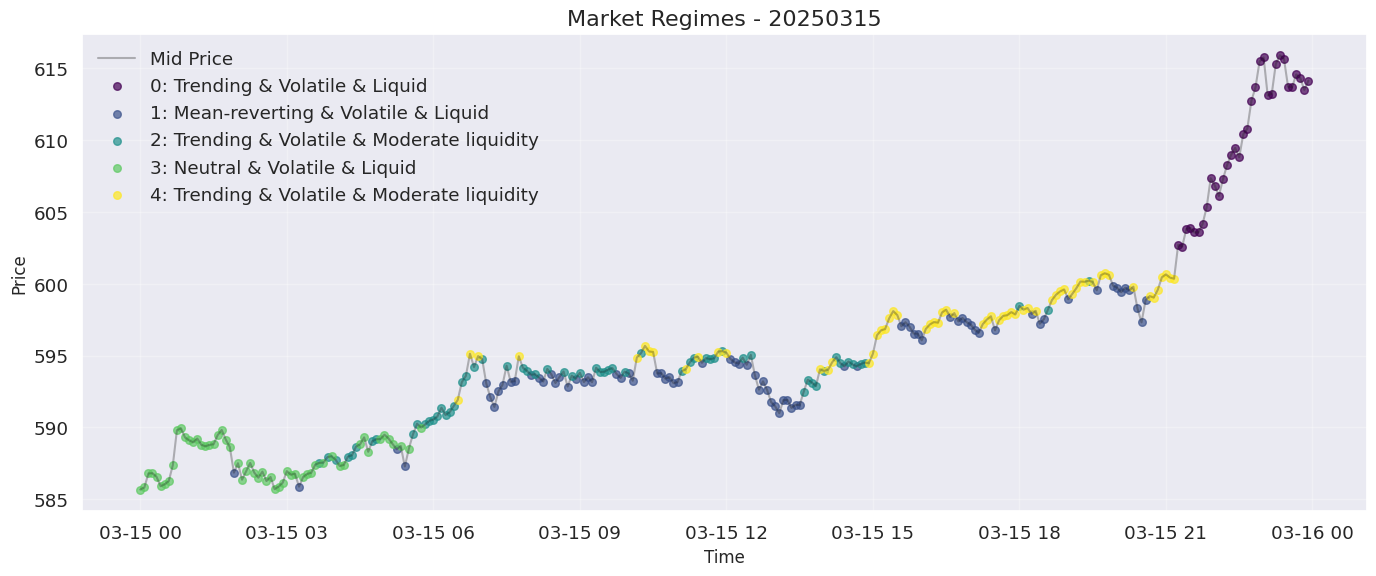

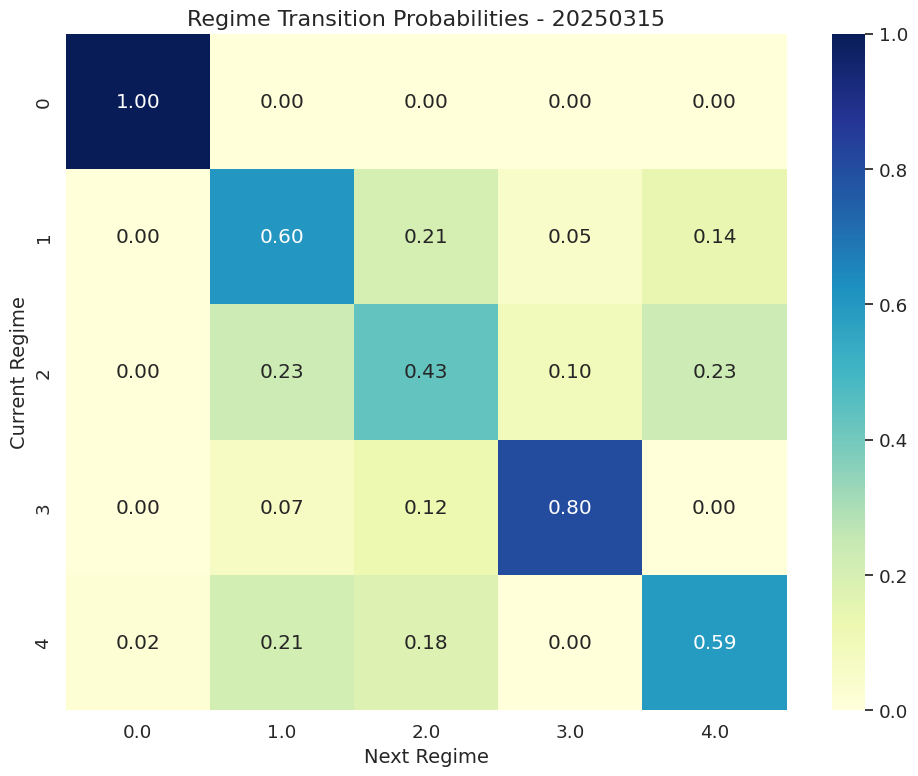


Analyzing data for 20250316
Extracting order book features...
Extracting trade features...
Combining features...
Adding derived features...

Detecting market regimes with 5 clusters...
Silhouette Score: 0.0962

Characterizing market regimes...

Regime Characteristics:
- Regime 0: Neutral & Volatile & Liquid
- Regime 1: Mean-reverting & Volatile & Liquid
- Regime 2: Mean-reverting & Volatile & Moderate liquidity
- Regime 3: Neutral & Volatile & Liquid
- Regime 4: Trending & Volatile & Liquid

Visualizing market regimes...


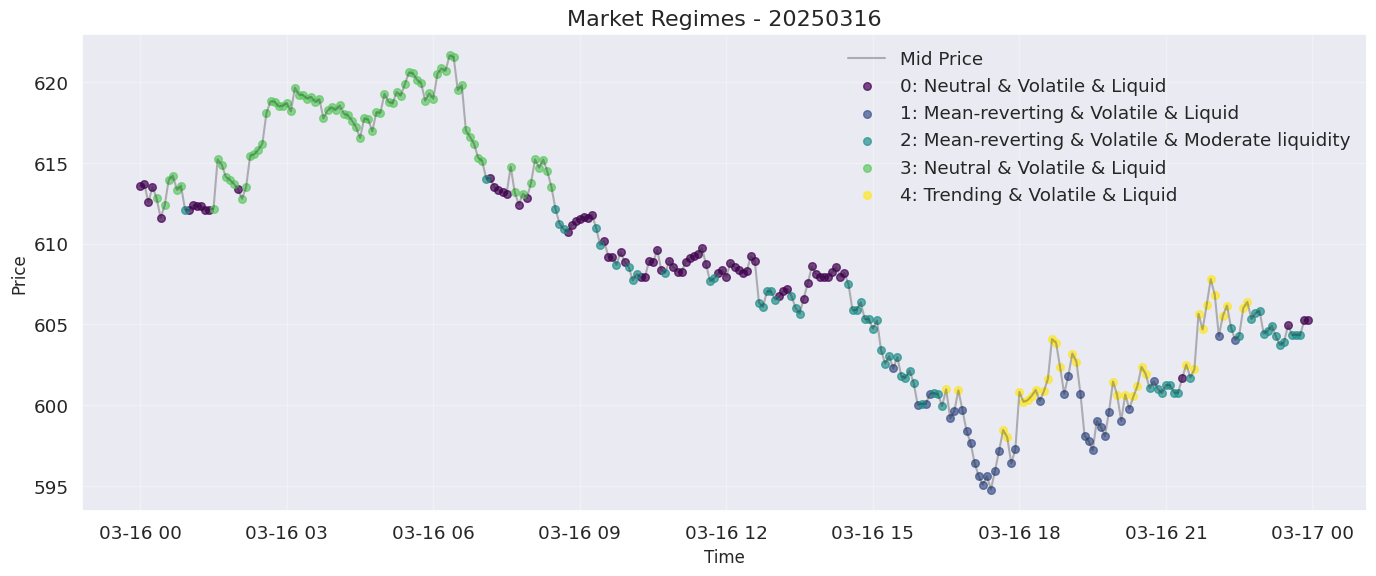

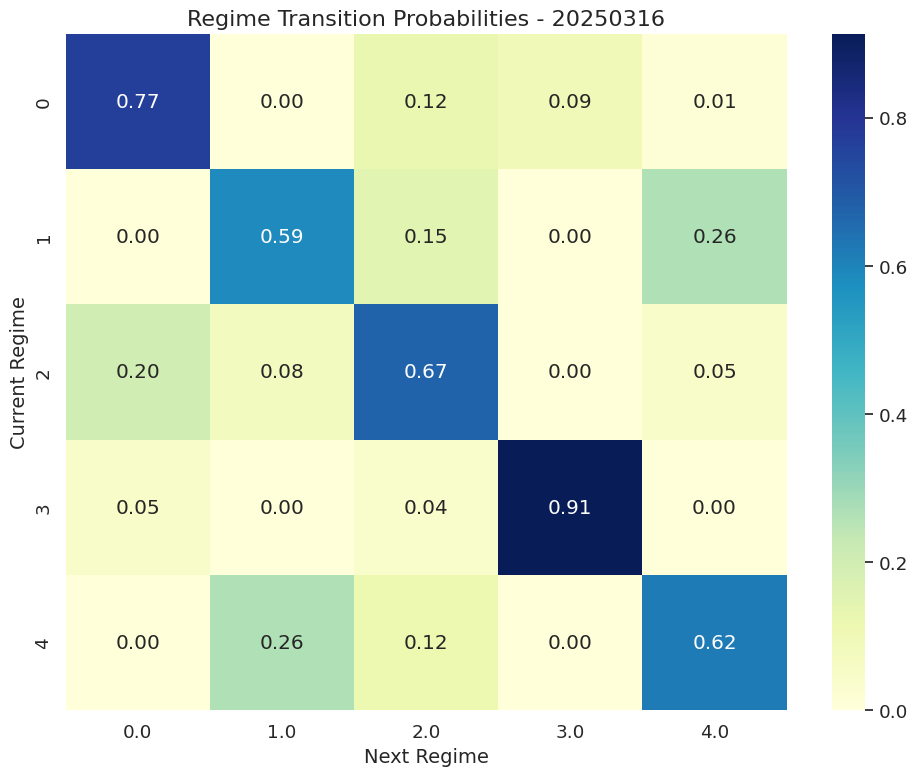


MARKET REGIME DETECTION SUMMARY REPORT

Date: 20250314
------------------------------
Regime Distribution:
  Regime 0 (Trending & Volatile & Liquid): 50 points (17.42%)
  Regime 1 (Mean-reverting & Volatile & Liquid): 31 points (10.80%)
  Regime 2 (Mean-reverting & Volatile & Liquid): 60 points (20.91%)
  Regime 3 (Neutral & Volatile & Moderate liquidity): 67 points (23.34%)
  Regime 4 (Trending & Volatile & Liquid): 79 points (27.53%)

Time Spent in Each Regime:
  Regime 0: Start=06:10:00, End=23:45:00, Duration=17h 35m 0s
  Regime 1: Start=00:55:00, End=13:45:00, Duration=12h 50m 0s
  Regime 2: Start=00:05:00, End=18:45:00, Duration=18h 40m 0s
  Regime 3: Start=06:35:00, End=23:50:00, Duration=17h 15m 0s
  Regime 4: Start=00:00:00, End=19:15:00, Duration=19h 15m 0s

Regime Characteristics:

 Feature        | Regime 0 | Regime 1 | Regime 2 | Regime 3 | Regime 4
 --------------------------------------------------
 spread        |   0.0700 |   0.0717 |   0.0438 |   0.0433 |   0.0525
 v

In [26]:
def main():
    """Main execution function with memory optimization"""
    # Extract zip files
    extract_zip_files()

    # Find data files
    paired_files = find_data_files()

    if not paired_files:
        print("No data files found. Please upload the data files to Google Colab.")
        return

    # Load data files
    data_pairs = load_data_files(paired_files)

    if not data_pairs:
        print("Failed to load any data files.")
        return

    # Analyze each day
    all_results = {}
    all_cluster_dfs = {}
    all_regime_characteristics = {}

    # Use a fixed number of clusters for consistency and speed
    n_clusters = 5
    print(f"Using {n_clusters} clusters for all days for consistency and efficiency")

    for data_pair in data_pairs:
        try:
            # Analyze single day
            features_with_regimes, cluster_df, regime_characteristics = analyze_single_day(
                data_pair, n_clusters=n_clusters)

            # Store results
            all_results[data_pair['date']] = features_with_regimes
            all_cluster_dfs[data_pair['date']] = cluster_df
            all_regime_characteristics[data_pair['date']] = regime_characteristics

            # Free memory
            gc.collect()

        except Exception as e:
            print(f"Error analyzing data for {data_pair['date']}: {str(e)}")

    # Create summary report
    create_summary_report(all_results, all_cluster_dfs, all_regime_characteristics)

    print("\n" + "="*50)
    print("ANALYSIS COMPLETE")
    print("="*50)

# Execute main function
if __name__ == "__main__":
    main()
